In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

filename = "../data/npf_train.csv"

def read_data(path=filename):
    '''Read train/test data. Returns filtered out normalized data.'''
    data = pd.read_csv(path)                                                        # read the data
    class4 = list(map(lambda x: int(str_to_int(x)), data["class4"]))                # encode events into integers
    data = data.drop(columns=["id", "partlybad", "date", "class4"])                 # drop unnecessary columns
    data = data.iloc[:,[0,10,22,24,36,48,58,60,62,64,66,78,80,82,84,94,96,98]]      # choose important variables
    data = (data-data.mean()) / data.std()                                          # normalize the data
    data["class4"] = class4
    
    return data

def str_to_int(x):
    if x=="nonevent":
        return 0 
    elif x=="Ia":
        return 1
    elif x=="Ib":
        return 2
    else:
        return 3

In [78]:
def report_accuracies(y_pred, y_test, verbose=True):
    '''Calculate each class accuracy. Return multi class and binary accuracies.'''
    acc_0 = 0; acc_1 = 0; acc_2 = 0; acc_3 = 0 
    for i in range(len(y_pred)):
        if y_test[i] == 0 and y_pred[i] == 0:
            acc_0 += 1
        elif y_test[i] == 1 and y_pred[i] == 1:
            acc_1 += 1
        elif y_test[i] == 2 and y_pred[i] == 2:
            acc_2 += 1
        elif y_test[i] == 3 and y_pred[i] == 3:
            acc_3 += 1
            
    acc = np.mean(y_test==y_pred)
    
    if verbose:
        acc0 = acc_0 / (np.mean(y_test == 0)*len(y_test))
        acc1 = acc_1 / (np.mean(y_test == 1)*len(y_test))
        acc2 = acc_2 / (np.mean(y_test == 2)*len(y_test))
        acc3 = acc_3 / (np.mean(y_test == 3)*len(y_test))
        
        print(f"Accuracy for nonevent = {acc0:.4f} \t({acc_0}/{int((np.mean(y_test == 0)*len(y_test)))})")
        print(f"Accuracy for event Ia = {acc1:.4f} \t({acc_1}/{int((np.mean(y_test == 1)*len(y_test)))})")
        print(f"Accuracy for event Ib = {acc2:.4f} \t({acc_2}/{int((np.mean(y_test == 2)*len(y_test)))})")
        print(f"Accuracy for event II = {acc3:.4f} \t({acc_3}/{int((np.mean(y_test == 3)*len(y_test)))})")
        print(f"Accuracy overall = {acc:.4f}")

    # calculate binary accuracy
    for i, y in enumerate(y_pred):
        if y != 0:
            y_pred[i] = 1
        if y_test[i] != 0:
            y_test[i] = 1
            
    bin_acc = np.mean(y_pred == y_test)
    
    return acc, bin_acc

def split_train_test(data, a=0.5):
    '''Split each class evenly.'''
    X_nonevent, y_nonevent = data.loc[data["class4"] == 0].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 0].values
    X_Ia, y_Ia = data.loc[data["class4"] == 1].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 1].values
    X_Ib, y_Ib = data.loc[data["class4"] == 2].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 2].values
    X_II, y_II = data.loc[data["class4"] == 3].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 3].values

    # Split each class into equal size train and test
    X_nonevent_train, X_nonevent_test, y_nonevent_train, y_nonevent_test = train_test_split(X_nonevent, y_nonevent, test_size=a)
    X_Ia_train, X_Ia_test, y_Ia_train, y_Ia_test = train_test_split(X_Ia, y_Ia, test_size=a)
    X_Ib_train, X_Ib_test, y_Ib_train, y_Ib_test = train_test_split(X_Ib, y_Ib, test_size=a)
    X_II_train, X_II_test, y_II_train, y_II_test = train_test_split(X_II, y_II, test_size=a)

    # Recreate the mixed class train and test data (full data)
    X_train = np.vstack([X_nonevent_train, X_Ia_train, X_Ib_train, X_II_train])
    X_test = np.vstack([X_nonevent_test, X_Ia_test, X_Ib_test, X_II_test])
    y_train = np.hstack([y_nonevent_train, y_Ia_train, y_Ib_train, y_II_train])
    y_test = np.hstack([y_nonevent_test, y_Ia_test, y_Ib_test, y_II_test])
    
    return X_train, X_test, y_train, y_test

In [2]:
train_data = pd.read_csv(filename).drop(columns=["id", "partlybad", "date"])
train_data['class2'] = np.where(train_data['class4'] != 'nonevent', 'event', 'nonevent')

def group_by_column(column):
    columns = ["CO2336.mean","CO2336.std","H2O336.mean","H2O336.std","UV_A.mean"]
    return train_data.groupby(column).mean().loc[:,columns]

print(group_by_column("class2"))

          CO2336.mean  CO2336.std  H2O336.mean  H2O336.std  UV_A.mean
class2                                                               
event      378.727227    3.006002     6.152763    0.613853  14.238184
nonevent   383.301077    3.585138     8.323450    0.529336   7.684289


In [3]:
train_data.head()

,class4,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,...,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,class2
0,nonevent,384.462000,2.284996,384.164462,2.135062,385.274688,2.211695,383.885077,1.955198,19.245511,...,0.525698,-12.422972,0.376324,1.635563,0.856948,0.026438,0.014617,0.003374,0.000733,nonevent
1,nonevent,374.884615,0.415185,374.703333,0.385179,375.621266,0.665720,374.674177,0.435480,31.107659,...,0.373927,-8.351043,0.575679,1.441109,0.741088,0.022649,0.012479,0.001501,0.000572,nonevent
2,nonevent,373.496585,0.189497,373.382593,0.172958,373.961481,0.235107,373.275062,0.165500,29.800885,...,0.965988,-9.651155,1.238891,2.677545,1.261612,0.044759,0.023748,0.000764,0.000048,nonevent
3,nonevent,378.600367,1.934180,378.464862,1.946536,379.785872,2.865022,378.316909,1.983430,23.795211,...,0.122651,-0.829524,0.134191,2.261805,1.345651,0.030893,0.021903,0.002038,0.000751,nonevent
4,Ib,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,...,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210,event


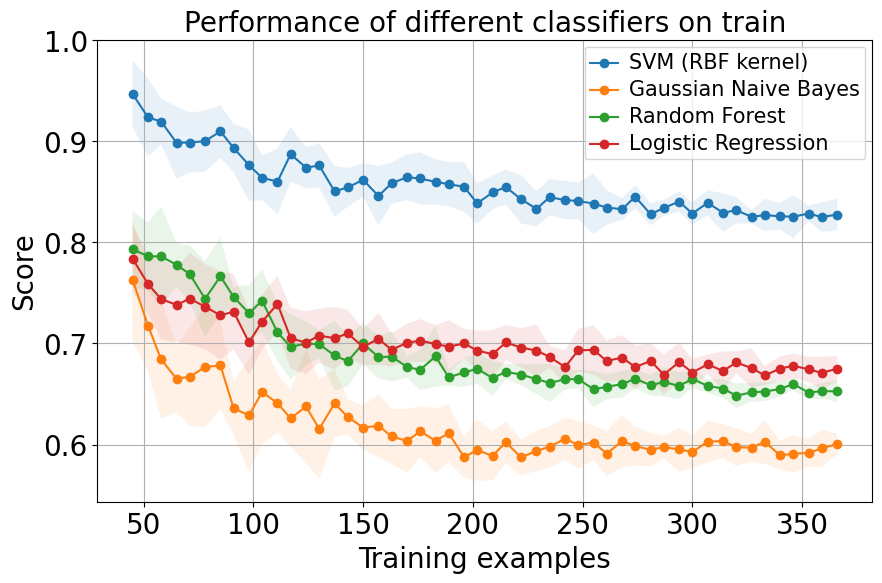

In [130]:
svc = SVC(kernel='rbf', C=3.75, tol=1e-8)
NB = GaussianNB()
RFC = RandomForestClassifier(max_depth=2, random_state=0)
LR = LogisticRegression(penalty="l1", solver="liblinear", max_iter=100000, tol=1e-6)
estimators = [svc, NB, RFC, LR]
names = ["SVM (RBF kernel)", "Gaussian Naive Bayes", "Random Forest", "Logistic Regression"]
n=20
k=10
n_points=50
multi_acc = True

data = read_data()
train_ratios = np.linspace(0.1, 0.8, n_points)
train_sizes = np.asarray(train_ratios * len(data), dtype=np.int32)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Performance of different classifiers on train", fontsize=n)
ax.set_xlabel("Training examples", fontsize=n)
ax.set_ylabel("Score", fontsize=n)
ax.tick_params(labelsize=n)
ax.grid()

train_scores, test_scores = np.zeros((2, k, n_points))

for name, estimator in zip(names,estimators):
    for i in range(k):
        for j, ratio in enumerate(train_ratios):
            X_train, X_test, y_train, y_test = split_train_test(data, a=1-ratio)

            estimator.fit(X_train, y_train)

            y_pred_train = estimator.predict(X_train)
            acc, acc_bin = report_accuracies(y_pred_train, y_train, verbose=0)
            train_acc = acc if multi_acc else acc_bin

            y_pred_test = estimator.predict(X_test)
            acc, acc_bin = report_accuracies(y_pred_test, y_test, verbose=0)
            test_acc = acc if multi_acc else acc_bin

            train_scores[i, j] = np.mean(train_acc)
            test_scores[i, j] = np.mean(test_acc)


    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)

    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
    )

    ax.plot(train_sizes, train_scores_mean, "o-", label=name)
    ax.legend(loc="best")

plt.setp(ax.get_legend().get_texts(), fontsize='15')    
plt.show()

In [131]:
fig.savefig("classifiers_train.png", dpi=600, bbox_inches='tight')

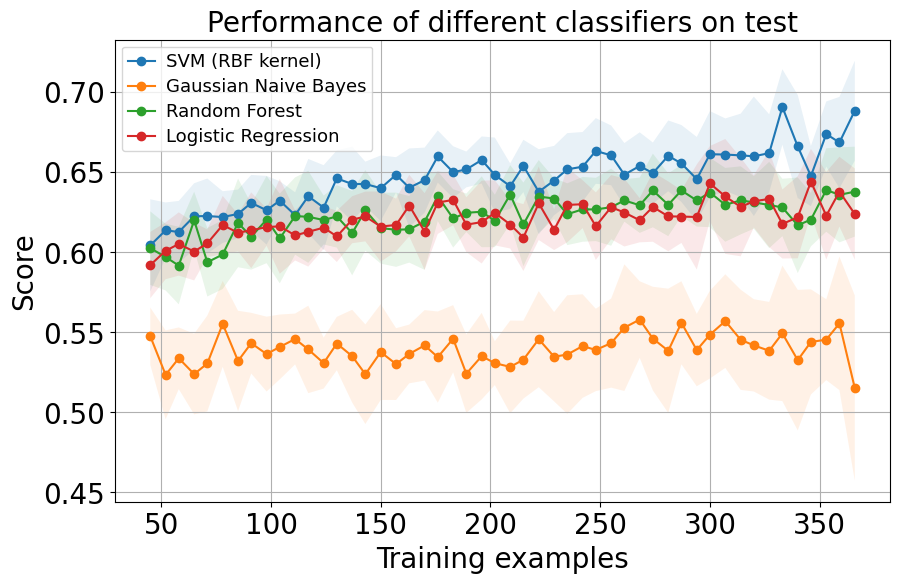

In [133]:
svc = SVC(kernel='rbf', C=3.75, tol=1e-8)
NB = GaussianNB()
RFC = RandomForestClassifier(max_depth=2, random_state=0)
LR = LogisticRegression(penalty="l1", solver="liblinear", max_iter=100000, tol=1e-6)
estimators = [svc, NB, RFC, LR]
names = ["SVM (RBF kernel)", "Gaussian Naive Bayes", "Random Forest", "Logistic Regression"]
n=20
k=10
n_points=50
multi_acc = True

data = read_data()
train_ratios = np.linspace(0.1, 0.8, n_points)
train_sizes = np.asarray(train_ratios * len(data), dtype=np.int32)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Performance of different classifiers on test", fontsize=n)
ax.set_xlabel("Training examples", fontsize=n)
ax.set_ylabel("Score", fontsize=n)
ax.tick_params(labelsize=n)
ax.grid()
    
train_scores, test_scores = np.zeros((2, k, n_points))

for name, estimator in zip(names,estimators):
    for i in range(k):
        for j, ratio in enumerate(train_ratios):
            X_train, X_test, y_train, y_test = split_train_test(data, a=1-ratio)

            estimator.fit(X_train, y_train)

            y_pred_train = estimator.predict(X_train)
            acc, acc_bin = report_accuracies(y_pred_train, y_train, verbose=0)
            train_acc = acc if multi_acc else acc_bin

            y_pred_test = estimator.predict(X_test)
            acc, acc_bin = report_accuracies(y_pred_test, y_test, verbose=0)
            test_acc = acc if multi_acc else acc_bin

            train_scores[i, j] = np.mean(train_acc)
            test_scores[i, j] = np.mean(test_acc)


    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)

    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )

    ax.plot(train_sizes, test_scores_mean, "o-", label=name)
    ax.legend(loc="best")

plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.show()

In [134]:
fig.savefig("classifiers_test.png", dpi=600, bbox_inches='tight')

In [137]:
def plot_learning_curve(estimator, title, fig, ax, multi_acc=True, k=10, n_points=10):
    data = read_data()
    train_ratios = np.linspace(0.1, 0.8, n_points)
    train_sizes = np.asarray(train_ratios * len(data), dtype=np.int32)

    n=20
    ax.set_title(title, fontsize=n)
    ax.set_xlabel("Training examples", fontsize=n)
    ax.set_ylabel("Score", fontsize=20)
    ax.tick_params(labelsize=n)
    
    train_scores, test_scores = np.zeros((2, k, n_points))
    
    for i in range(k):
        for j, ratio in enumerate(train_ratios):
            X_train, X_test, y_train, y_test = split_train_test(data, a=1-ratio)
            
            estimator.fit(X_train, y_train)
            
            y_pred_train = estimator.predict(X_train)
            acc, acc_bin = report_accuracies(y_pred_train, y_train, verbose=0)
            train_acc = acc if multi_acc else acc_bin
            
            y_pred_test = estimator.predict(X_test)
            acc, acc_bin = report_accuracies(y_pred_test, y_test, verbose=0)
            test_acc = acc if multi_acc else acc_bin

            train_scores[i, j] = np.mean(train_acc)
            test_scores[i, j] = np.mean(test_acc)
            
            
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training accuracy")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Test accuracy")
    ax.legend(loc="best")
    
    plt.setp(ax.get_legend().get_texts(), fontsize='20')   
    plt.show()
    return fig

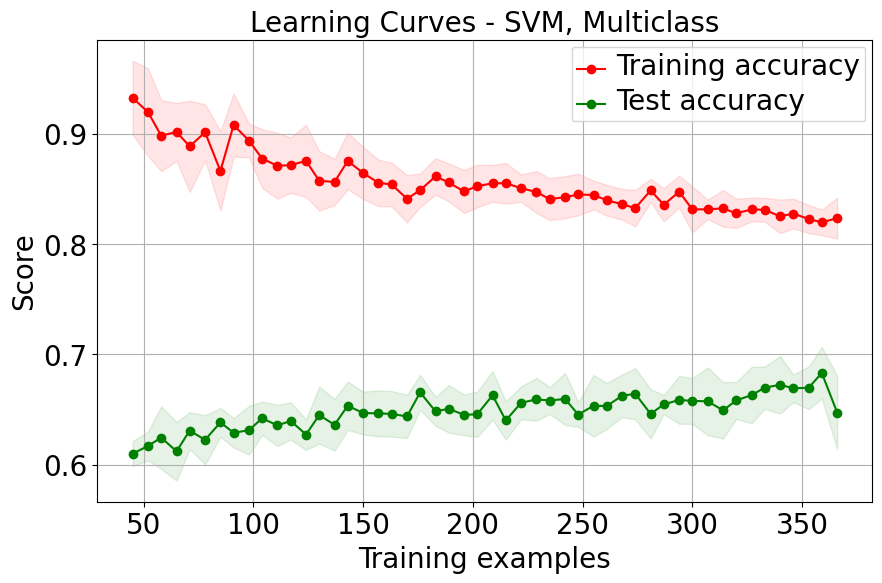

In [138]:
# Plot learning curve for multiclass
plt.style.use("default")
title = "Learning Curves - SVM, Multiclass"
estimator = SVC(kernel='rbf', C=3.75, tol=1e-8)
fig, ax = plt.subplots(figsize=(10, 6))
fig = plot_learning_curve(estimator, title, fig, ax, k=10, n_points=50)

In [139]:
fig.savefig("learning_train_test_svm.png", dpi=600, bbox_inches='tight')

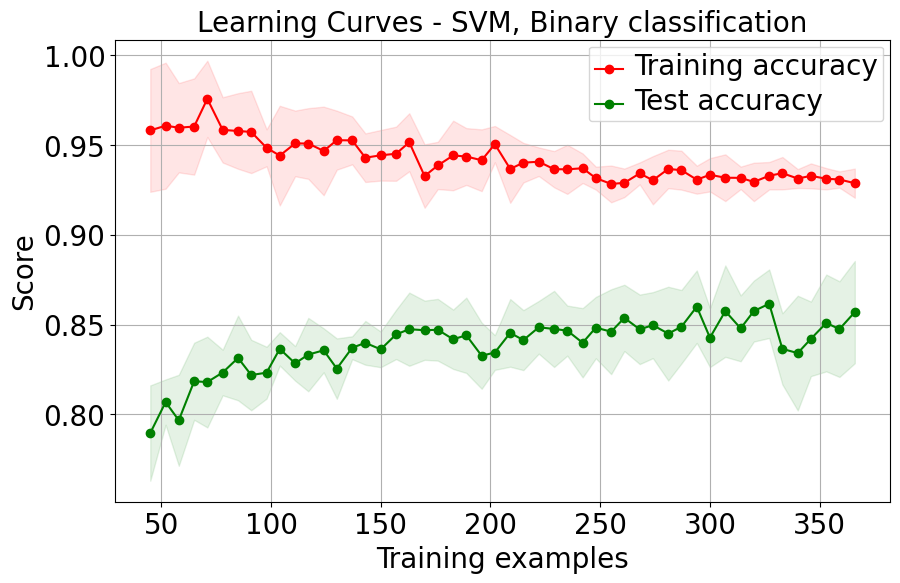

In [140]:
# Plot learning curve for binaryclass
title = "Learning Curves - SVM, Binary classification"
estimator = SVC(kernel='rbf', C=3.75, tol=1e-8)
fig, ax = plt.subplots(figsize=(10, 6))
fig = plot_learning_curve(estimator, title, fig, ax, k=10, n_points=50, multi_acc=False)

In [141]:
fig.savefig('learning_train_test_svm_binary.png', dpi=600, bbox_inches='tight')

In [142]:
def plot_c_values(title, search_space, fig, ax, multi_acc=True, k=10):
    data = read_data()

    c_values = search_space
    n_points = len(search_space)
    
    n=20
    ax.set_title(title, fontsize=n)
    ax.set_xlabel(r"$C$", fontsize=n)
    ax.set_ylabel("Score", fontsize=n)
    ax.tick_params(labelsize=n)
    
    train_scores, test_scores = np.zeros((2, k, n_points))
    
    for i in range(k):
        for j, c in enumerate(c_values):
            X_train, X_test, y_train, y_test = split_train_test(data, a=0.2)
            estimator = SVC(kernel='rbf', C=c, tol=1e-8)
            
            estimator.fit(X_train, y_train)
            
            y_pred_train = estimator.predict(X_train)
            acc, acc_bin = report_accuracies(y_pred_train, y_train, verbose=0)
            train_acc = acc if multi_acc else acc_bin
            
            y_pred_test = estimator.predict(X_test)
            acc, acc_bin = report_accuracies(y_pred_test, y_test, verbose=0)
            test_acc = acc if multi_acc else acc_bin

            train_scores[i, j] = np.mean(train_acc)
            test_scores[i, j] = np.mean(test_acc)
            
            
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)

    ax.grid()
    ax.fill_between(
        c_values,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        c_values,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    ax.plot(c_values, train_scores_mean, "o-", color="r", label="Training accuracy")
    ax.plot(c_values, test_scores_mean, "o-", color="g", label="Test accuracy")
    ax.legend(loc="best")
    
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    plt.show()
    
    return fig

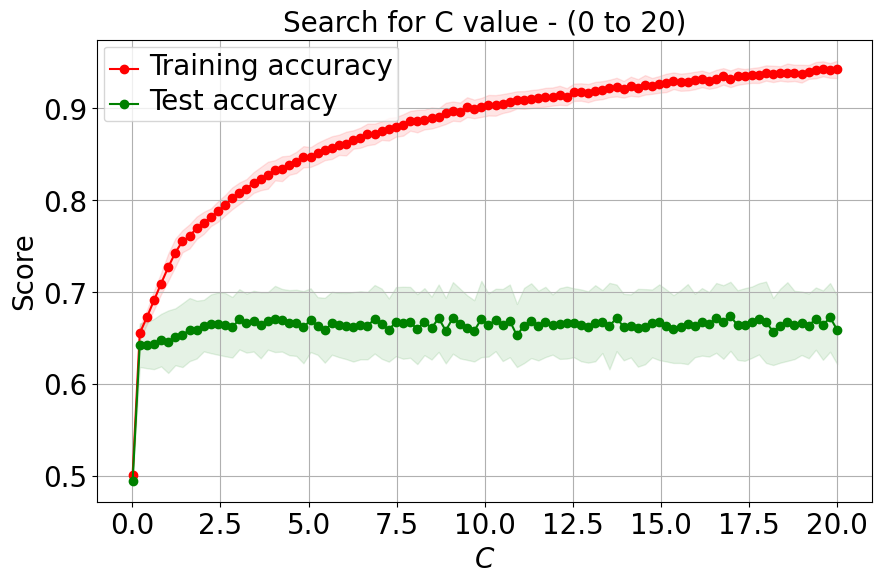

In [144]:
fig, ax = plt.subplots(figsize=(10, 6))
fig = plot_c_values("Search for C value - (0 to 20)", np.linspace(0.01, 20.0, 100), fig, ax, multi_acc=True, k=100)

In [145]:
fig.savefig('Cvalues.png', dpi=600, bbox_inches='tight')

In [48]:
train_data = train_data.rename(columns={"class2":"Type of event", "class4":"Event type"})
X = train_data.iloc[:,1:-1]
y_2 = train_data.iloc[:,-1]
y_4 = train_data.iloc[:,0]

X_stand = StandardScaler().fit_transform(X)

pca = PCA().fit(X_stand)
X_pca = pca.transform(X_stand)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
sns.kdeplot(x = X_pca[:,0], hue = y_2, ax = ax1)
sns.kdeplot(x = X_pca[:,1], hue = y_2, ax = ax2, legend = False)
sns.kdeplot(x = X_pca[:,2], hue = y_2, ax = ax3, legend = False)

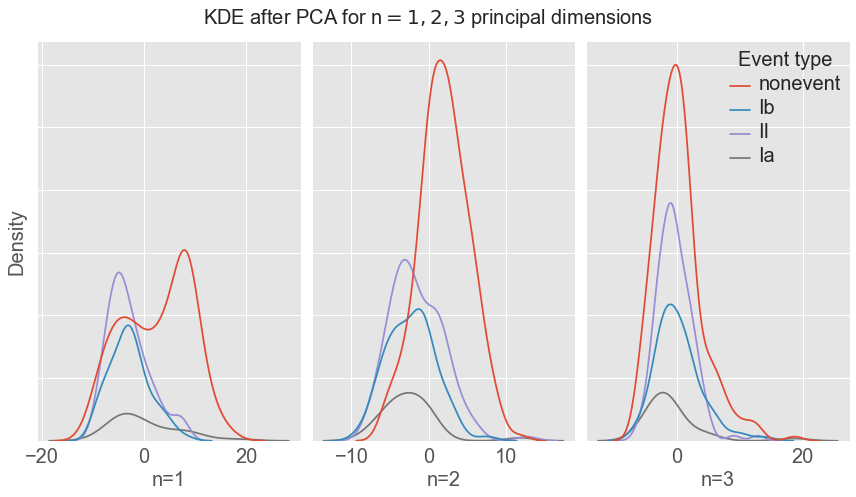

In [74]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 7), ncols=3, sharey=True)
sns.kdeplot(x = X_pca[:,0], hue = y_4, ax = ax1, legend=False)
sns.kdeplot(x = X_pca[:,1], hue = y_4, ax = ax2, legend = False)
sns.kdeplot(x = X_pca[:,2], hue = y_4, ax = ax3)

n = 20
ax1.set_xlabel(r"n=1", fontsize=n)
ax1.set_ylabel("Density", fontsize=n)
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlabel(r"n=2", fontsize=n)
ax2.set_ylabel("")
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax3.set_xlabel(r"n=3", fontsize=n)
ax3.set_ylabel("")
ax3.yaxis.set_major_formatter(plt.NullFormatter())

ax1.tick_params(labelsize=n)
ax2.tick_params(labelsize=n)#, axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
ax3.tick_params(labelsize=n)#, axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

fig.suptitle(r"KDE after PCA for n$=1,2,3$ principal dimensions", fontsize=20)
plt.setp(ax3.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax3.get_legend().get_title(), fontsize='20')
plt.tight_layout()

In [75]:
fig.savefig('kde_multi_pca.png', dpi=600, bbox_inches='tight')

In [6]:
train_data = train_data.rename(columns={"class2":"Type of event"})
train_data.head()

,class4,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,...,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,Type of event
0,nonevent,384.462000,2.284996,384.164462,2.135062,385.274688,2.211695,383.885077,1.955198,19.245511,...,0.525698,-12.422972,0.376324,1.635563,0.856948,0.026438,0.014617,0.003374,0.000733,nonevent
1,nonevent,374.884615,0.415185,374.703333,0.385179,375.621266,0.665720,374.674177,0.435480,31.107659,...,0.373927,-8.351043,0.575679,1.441109,0.741088,0.022649,0.012479,0.001501,0.000572,nonevent
2,nonevent,373.496585,0.189497,373.382593,0.172958,373.961481,0.235107,373.275062,0.165500,29.800885,...,0.965988,-9.651155,1.238891,2.677545,1.261612,0.044759,0.023748,0.000764,0.000048,nonevent
3,nonevent,378.600367,1.934180,378.464862,1.946536,379.785872,2.865022,378.316909,1.983430,23.795211,...,0.122651,-0.829524,0.134191,2.261805,1.345651,0.030893,0.021903,0.002038,0.000751,nonevent
4,Ib,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,...,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210,event


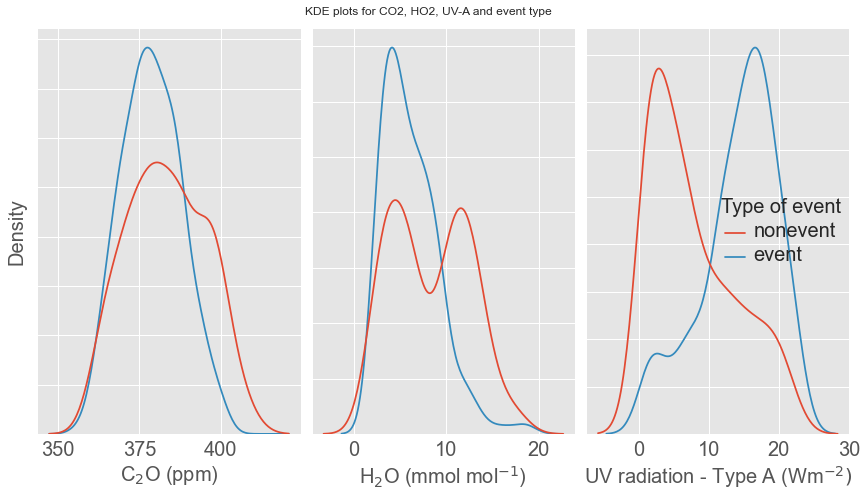

In [64]:
#plt.style.use('seaborn')
plt.style.use('ggplot')

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 7), ncols=3)
train_data = train_data.rename(columns={"CO2336.mean": "CO2 (p pm)", "H2O336.mean":"H2O (mmol mol^-1)", "UV_A.mean":"UV radiation - Type A (Wm^-2)"})
y_2 = train_data.iloc[:, -1]
sns.kdeplot(x = train_data.loc[:,"CO2 (ppm)"], hue = y_2, ax = ax1, common_grid=True, legend=False)
sns.kdeplot(x = train_data.loc[:,"H2O (mmol mol^-1)"], hue = y_2, ax = ax2, legend = False)
sns.kdeplot(x = train_data.loc[:,"UV radiation - Type A (Wm^-2)"], hue = y_2, ax = ax3)

n = 20
ax1.set_xlabel(r"C$_2$O (ppm)", fontsize=n)
ax1.set_ylabel("Density", fontsize=n)
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlabel(r"H$_2$O (mmol mol$^{-1}$)", fontsize=n)
ax2.set_ylabel("")
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax3.set_xlabel(r"UV radiation - Type A (Wm$^{-2})$", fontsize=n)
ax3.set_ylabel("")
ax3.yaxis.set_major_formatter(plt.NullFormatter())

ax1.tick_params(labelsize=n)
ax2.tick_params(labelsize=n)#, axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
ax3.tick_params(labelsize=n)#, axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

fig.suptitle("KDE plots for CO2, HO2, UV-A and event type")
plt.setp(ax3.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax3.get_legend().get_title(), fontsize='20')
plt.tight_layout()

In [58]:
fig.savefig('kde_binary_co2_ho2_uva.png', dpi=600, bbox_inches='tight')

In [9]:
for c in X.columns:
    if ".mean" in c:
        X = X.rename(columns={str(c):str(c)[:-5]})

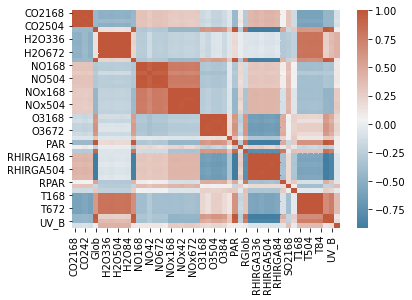

In [ ]:
correlation = X.loc[:,['std' not in i for i in X.columns]].corr()
heatmap = sns.heatmap(correlation, cmap = sns.diverging_palette(235, 21, as_cmap=True))
fig = heatmap.get_figure()

plt.show()

In [ ]:
fig.savefig('correlated_heatmap.png', dpi=600, bbox_inches='tight')

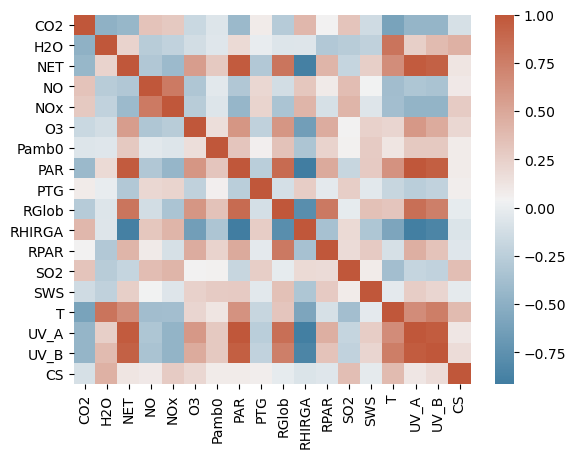

In [146]:
import seaborn as sns
X = read_data().drop(columns="class4")
for c in X.columns:
    if ".mean" in c:
        X = X.rename(columns={str(c):str(c)[:-5]})
X = X.rename(columns={"CO2168":"CO2", "H2O168":"H2O", "NO168":"NO", "NOx168":"NOx", "O3168":"O3", "RHIRGA168":"RHIRGA", 
                      "SO2168":"SO2", "T168":"T"})

correlation = X.loc[:,['std' not in i for i in X.columns]].corr()
heatmap = sns.heatmap(correlation, cmap = sns.diverging_palette(235, 21, as_cmap=True))
fig = heatmap.get_figure()

plt.show()

In [ ]:
fig.savefig('final_heatmap.png', dpi=600, bbox_inches='tight')